In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from optimize_satellite import optimize_satellite
from pathlib import Path

# Import from drag.py
from drag import (
    compute_aoa_and_area,
    load_c_d_lookup_table,
    compute_elementwise_drag,
)
from body import verify_normals_outward

Starting Genetic Algorithm optimization...
Generation 1/1: Best fitness = 6.629826
GA optimization completed. Best fitness: 6.629826
Normal check: 0 outward, 160 inward


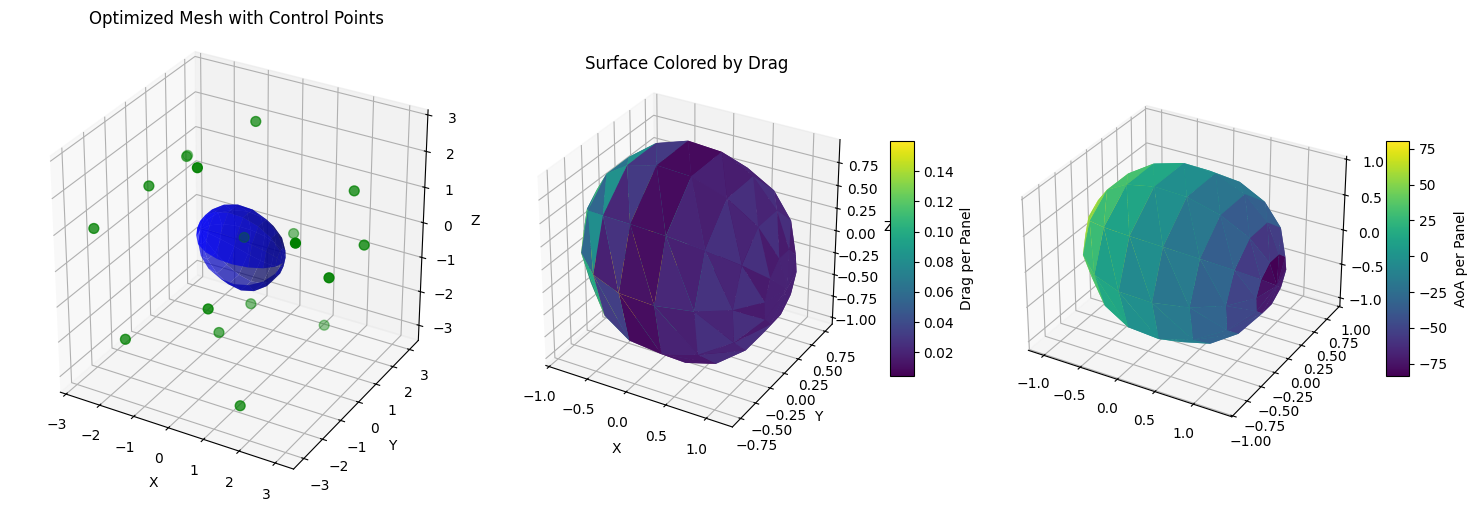

In [3]:
cwd = Path.cwd()

# Define a bounding box that properly contains the sphere
bbox_min = [-2.0, -2.0, -2.0]
bbox_max = [2.0, 2.0, 2.0]

# Origin geometry parameters - sphere centered in the FFD box
radius = 1.0
center = (0.0, 0.0, 0.0)

# Create a higher resolution lattice for better shape control
lattice_shape = (3, 2, 3)  # Odd number in Y direction for proper symmetry

# maximum body length and minimum volume constraints
L_max = 5.0  # Reduced to match the new scale
V_min = 4 / 3 * np.pi * radius**3  # Reduced to match smaller sphere (4/3*π*1^3 ≈ 4.19)


lookup_table = load_c_d_lookup_table(
    f"{cwd}/../src/coeffs/aerodynamic_coefficients_panel_method.csv"
)

# Optimize the satellite mesh
n_phi, n_theta = 10, 10  # Higher resolution mesh
n_iter = 1  # More generations for genetic algorithm
optimized_vertices, ffd, panels = optimize_satellite(
    bbox_min,
    bbox_max,
    lattice_shape,
    L_max,
    V_min,
    n_iter,
    radius,
    center,
    lookup_table,
    n_phi,
    n_theta,
)

# Compute elementwise drag for the optimized mesh
aoas, areas = compute_aoa_and_area(panels, optimized_vertices)
elementwise_drag = compute_elementwise_drag(aoas, areas, lookup_table)

# Check if normals are outward
if not verify_normals_outward(optimized_vertices, panels):
    print("Warning: Normals are not outward. The mesh may be inside-out.")

# Plot the optimized mesh
fig = plt.figure(figsize=(15, 5))

# First subplot: Optimized mesh with control points
ax1 = fig.add_subplot(131, projection="3d")
x = optimized_vertices[:, 0].reshape(n_phi, n_theta)
y = optimized_vertices[:, 1].reshape(n_phi, n_theta)
z = optimized_vertices[:, 2].reshape(n_phi, n_theta)
ax1.plot_surface(x, y, z, color="blue", alpha=0.7, label="Optimized Mesh")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Optimized Mesh with Control Points")

# Plot the control points
ax1.scatter(
    ffd.P[:, :, :, 0], ffd.P[:, :, :, 1], ffd.P[:, :, :, 2], color="green", s=50
)
ax1.set_box_aspect([1, 1, 1])  # Equal aspect

# Second subplot: Surface colored by elementwise drag
ax2 = fig.add_subplot(132, projection="3d")

# Create triangles for 3D plotting
triangles = []
colors = []

for i, panel in enumerate(panels):
    # Get triangle vertices
    p1, p2, p3 = (
        optimized_vertices[panel[0]],
        optimized_vertices[panel[1]],
        optimized_vertices[panel[2]],
    )
    triangle = [p1, p2, p3]
    triangles.append(triangle)

    # Color based on drag value
    drag = elementwise_drag[i]
    normalized_drag = drag / np.max(elementwise_drag)  # Normalize to [0, 1]
    color = plt.cm.viridis(normalized_drag)
    colors.append(color)

# Create 3D polygon collection
poly3d = Poly3DCollection(triangles, facecolors=colors, edgecolors="none")
ax2.add_collection3d(poly3d)

# Set axis limits based on optimized vertices
ax2.set_xlim(np.min(optimized_vertices[:, 0]), np.max(optimized_vertices[:, 0]))
ax2.set_ylim(np.min(optimized_vertices[:, 1]), np.max(optimized_vertices[:, 1]))
ax2.set_zlim(np.min(optimized_vertices[:, 2]), np.max(optimized_vertices[:, 2]))

ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title("Surface Colored by Drag")
ax2.set_box_aspect([1, 1, 1])  # Equal aspect

# Add colorbar for aoas
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=np.min(elementwise_drag), vmax=np.max(elementwise_drag)),
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, shrink=0.5, aspect=10)
cbar.set_label("Drag per Panel")

# Plot the angle of attack as a color
aoas, areas = compute_aoa_and_area(
    panels, optimized_vertices, incident_velocity=np.array([-1, 0, 0])
)

# Second subplot: Surface colored by aoas
ax3 = fig.add_subplot(133, projection="3d")

# Create triangles for 3D plotting
colors_aoas = []
for i, panel in enumerate(panels):
    # Color based on drag value
    aoa = aoas[i]
    aoa_normed = (aoa - np.min(aoas)) / (np.max(aoas) - np.min(aoas))
    color = plt.cm.viridis(aoa_normed)  # Use colormap to get color
    colors_aoas.append(color)

# Create 3D polygon collection
poly3d = Poly3DCollection(triangles, facecolors=colors_aoas, edgecolors="none")
ax3.add_collection3d(poly3d)

# Add colorbar for drag values
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis, norm=plt.Normalize(vmin=np.min(aoas), vmax=np.max(aoas))
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax3, shrink=0.5, aspect=10)
cbar.set_label("AoA per Panel")

plt.tight_layout()

plt.show()